In [1]:
import numpy as np
from pathlib import Path
from fastdtw import fastdtw
import igl
import networkx as nx
from scipy.interpolate import splprep, splev, make_splprep
from scipy.spatial import KDTree

import plotly.graph_objects as go
import plotly.express as px

from typing import List, Optional, Tuple
from numpy.typing import NDArray

import matplotlib.pyplot as plt

In [17]:
class FoldAnnotation:
    @staticmethod
    def _align_paths_with_dtw(paths):
        from scipy.spatial.distance import euclidean
        # Choose a reference path (first path in this case)
        ref_path = paths[0]

        # List to store aligned paths
        aligned_paths = []

        for path in paths:
            # Compute the DTW distance and the alignment path
            distance, alignment_path = fastdtw(ref_path, path, dist=euclidean)
            # Align path to the reference path
            aligned_path = np.array([path[idx] for idx in list(zip(*alignment_path))[1]])
            aligned_paths.append(aligned_path)
        return aligned_paths
    @staticmethod
    def _resample_path(path, num_points):
        from scipy.interpolate import interp1d
        original_indices = np.linspace(0, 1, len(path))
        target_indices = np.linspace(0, 1, num_points)

        interpolator = interp1d(original_indices, path, axis=0, kind='linear', fill_value="extrapolate")
        resampled_path = interpolator(target_indices)
        return resampled_path
    @staticmethod
    def _average_aligned_paths(aligned_paths, num_points):
        resampled_paths = [FoldAnnotation._resample_path(path, num_points) for path in aligned_paths]
        stacked_paths = np.stack(resampled_paths)
        avg_path = np.mean(stacked_paths, axis=0)
        err_path = np.sqrt(np.var(stacked_paths, axis=0).sum(axis=-1))
        return avg_path, err_path
    

    def __init__(self,
                 vertices, 
                 triangles, 
                 vertex_mean_curvature, 
                 indices,

                 path_through_positive_curvature : bool,
                 alpha  : float,
                 vertex_adj_list = Optional[List[List[int]]],
                 path_quantile_level= 0.1,
                 restrict_path_to_boundary = False                 ):
        self.vertices = vertices
        self.triangles = triangles
        self.vertex_mean_curvature = vertex_mean_curvature
        self.indices = indices    
        if vertex_adj_list is not None:
            self.vertex_adj_list = vertex_adj_list
        else:
            self.vertex_adj_list = igl.adjacency_list(triangles)
        self.vertex_adj_graph = nx.from_dict_of_lists({i: nbrs for i, nbrs in enumerate(self.vertex_adj_list)})
        self.vertex_normals = igl.per_vertex_normals(self.vertices, self.triangles)
        self.triangle_centers = np.mean(self.vertices[self.triangles], axis=1)
        self.triangle_normals = igl.per_face_normals(self.vertices, self.triangles)
        self.boundary_region_indices = np.unique(np.array(list(nx.edge_boundary(self.vertex_adj_graph, self.indices)))[:,0])
        self._vertex_weights = None

        self._start_indices = None
        self._end_indices = None
        self._vpath_indices = None
        self._vpath_indices_weights = None
        
        self._vpaths = None


        self._tpath_indices = None
        self._tpath_indices_projections = None

        self._merged_vpath_indices = None
        self._merged_vpath = None
        self._merged_vpath_error = None



        self.path_through_positive_curvature = path_through_positive_curvature
        self.alpha = alpha
        self.path_quantile_level = path_quantile_level
        self.restrict_path_to_boundary = restrict_path_to_boundary


    def compute_vertex_weights(self):
        if self._vertex_weights is not None:
            return self._vertex_weights
        from_nodes = np.repeat(np.arange(0, len(self.vertices)), [len(nbrs) for nbrs in self.vertex_adj_list])
        to_nodes = np.concatenate(self.vertex_adj_list)
        self._vertex_weights =  np.exp( ( -1.0 if self.path_through_positive_curvature else 1.0) * self.alpha * (self.vertex_mean_curvature[from_nodes] + self.vertex_mean_curvature[to_nodes])/2.0)
        self._vertex_weights[~np.isfinite(self._vertex_weights)] = np.inf
        self.vertex_adj_graph.add_weighted_edges_from(zip(from_nodes, to_nodes, self._vertex_weights))
        
        return self._vertex_weights

        
    def estimate_ellipticity(self):
        '''
            We estimate the ellipticity of the region defined by 'indices'. We employ a nematic decomposition of the covariance matrix of the vertices defined by 'indices'. 
            We return two nematic order parameters, S and T, where s is the the nematic order and t is a measure of the biaxiality of the region.
            When S > 0, the region is elongated along the direction of largest variance, and when S < 0, the region is compressed along the direction of smallest variance.
    '''
        points = self.vertices[self.indices]
        points_cov = np.cov(points, rowvar=False, bias=True)
        vals, vecs = np.linalg.eigh(points_cov)

        q_vals = 0.5*np.log(vals)
        q_vals -= q_vals.sum()/3
        if abs(q_vals[0]) < q_vals[2]:
            s_val = q_vals[2]
            t_val = (q_vals[1] - q_vals[0])/2
        else:
            s_val = q_vals[0]
            t_val = (q_vals[2] - q_vals[1])/2

        return s_val, t_val
    def compute_vpath_boundary_indices(self) -> Tuple[NDArray[np.int_], NDArray[np.int_]]:
        '''
            Estimates using PCA on vertices selected by 'indices' the extremal vertices, taken along the direction of largest variance. 
            We retain points in the lower and upper quantiles along this direction, as determined by 'path_quantile_level' i.e. 
            quantiles at levels self.path_quantile_level and 1.0 - self.path_quantile_level.
        '''
        if self._start_indices is not None and self._end_indices is not None:
            return self._start_indices, self._end_indices
        points = self.vertices[self.indices]
        points_cov = np.cov(points, rowvar=False, bias=True)
        vals, vecs = np.linalg.eigh(points_cov)
        largest_eigvec = vecs[:, -1]
        projected_points = (points - points.mean(axis=0, keepdims=True)) @ largest_eigvec
        quantiles = np.quantile(projected_points, [self.path_quantile_level, 1.0 - self.path_quantile_level])
        start_indices =  self.indices[(projected_points < quantiles[0])]
        end_indices = self.indices[(projected_points > quantiles[1])]
        if self.restrict_path_to_boundary and len(self.boundary_region_indices) > 0:
            start_indices = np.intersect1d(start_indices, self.boundary_region_indices)
            end_indices = np.intersect1d(end_indices, self.boundary_region_indices)
            if len(start_indices) == 0 or len(end_indices) == 0:
                raise ValueError("No start or end indices found on boundary region. Consider disabling restrict_path_to_boundary.")
        self._start_indices = np.unique(start_indices)
        self._end_indices = np.unique(end_indices)
        return self._start_indices, self._end_indices   
    def compute_vpath_indices(self) -> Tuple[List[NDArray[np.int_]], NDArray[np.float64]]:
        '''
            We find using Djikstra's algorithm the shortest paths between all pairs of start and end indices, as determined by 'compute_vpath_boundary_indices'.
            We employ as weights between vertex 'i' and 'j' the value exp( alpha * (curvature(i) + curvature(j))/2.0) if 'path_through_positive_curvature' is True, 
            and exp( - alpha * (curvature(i) + curvature(j))/2.0) otherwise, where curvature(i) is the mean curvature at vertex i.
        '''
        if self._vpath_indices is not None:
            return self._vpath_indices, self._vpath_indices_weights
        subgraph = self.vertex_adj_graph.subgraph(self.indices)
        start_indices, end_indices = self.compute_vpath_boundary_indices()
        paths = []
        path_weights = []
        for v1 in start_indices:
            distances_1, paths_1 = nx.algorithms.single_source_dijkstra(subgraph, v1, weight='weight')
            for v2 in end_indices:
                if(v2  in paths_1):
                    path = paths_1[v2]
                    dist = distances_1[v2]
                    if not np.isfinite(dist):
                        continue
                    paths.append(np.array(path))
                    path_weights.append(dist)
        self._vpath_indices = paths
        self._vpath_indices_weights = np.array(path_weights)
        return self._vpath_indices, self._vpath_indices_weights
    def compute_vpaths(self) -> List[NDArray[np.float64]]:
        '''
            For each path, we return the 3D coordinates of the vertices along the path. 
        '''
        if self._vpaths is not None:
            return self._vpaths
        paths, _ = self.compute_vpath_indices()
        path_vertices = [self.vertices[path] for path in paths]
        self._vpaths = path_vertices
        return self._vpaths
        
    def merge_vpaths(self, num_points=100) -> Tuple[NDArray[np.int_], NDArray[np.float64], NDArray[np.float64]]:
        '''
            We merge the paths found by 'compute_vpath_indices' into a single path, by first aligning them using Dynamic Time Warping (DTW) and then averaging the aligned paths. 
            We return the indices of the vertices along the merged path, the 3D coordinates of the vertices along the merged path and the error estimate for each point of the merged path.
        '''
        if self._merged_vpath is not None and self._merged_vpath_error is not None:
            return self._merged_vpath_indices, self._merged_vpath, self._merged_vpath_error
        
        aligned_paths = self._align_paths_with_dtw(self.compute_vpaths())
        merged_path, merged_path_error = self._average_aligned_paths(aligned_paths, num_points=num_points)
        dists, sub_indices = KDTree(self.vertices[self.indices]).query(merged_path)
        self._merged_vpath_indices = self.indices[sub_indices]
        self._merged_vpath = self.vertices[self._merged_vpath_indices]
        self._merged_vpath_error = merged_path_error
        return self._merged_vpath_indices, self._merged_vpath, self._merged_vpath_error
    
    def compute_tpath_indices(self) -> Tuple[List[NDArray[np.int_]], List[NDArray[np.float64]]]:
        '''
            For each vertex in each path, we find the triangle it belongs to whose plane is closest to the vertex, and return the indices of these triangles, as well as the projection of the vertex onto the plane of the triangle. 
        '''
        if self._tpath_indices is not None and self._paths_on_triangle_indices_projections is not None:
            return self._tpath_indices, self._paths_on_triangle_indices_projections
        paths, _ = self.compute_vpath_indices()
        self._tpath_indices = []
        self._paths_on_triangle_indices_projections = []
        for path in paths:
            candidate_triangles = np.argwhere(np.isin(self.triangles, path).any(axis=1)).flatten()
            
            projection = np.sum(self.triangle_normals[None,candidate_triangles,:] * (self.vertices[path][:,None,:] - self.triangle_centers[None, candidate_triangles, :]), axis=-1)
            correct_indices = np.argmin(np.abs(projection), axis=1)
            self._tpath_indices.append(candidate_triangles[correct_indices])
            self._paths_on_triangle_indices_projections.append(projection[np.arange(len(path)), correct_indices])
        return self._tpath_indices, self._paths_on_triangle_indices_projections 


    def visualize(self, additional_curves : Optional[List] = None,
                  fig : Optional[go.Figure] = None, 
                  mesh_color = 'lightgrey', 
                  display_merged_path = False,
                  display_vpaths = False,
                  fraction_of_vpaths_to_display : float = 1.0,
                  show_fig = True):
        if fig is None:
            fig = go.Figure()
            fig.update_layout(
            title="",
            width=800, height=680,
            scene=dict(
                xaxis_title='x', yaxis_title='y', zaxis_title='z',
                aspectmode='data',
                uirevision="keep"  # preserve camera/zoom
            ),
            margin=dict(l=0, r=0, t=0, b=0),
            legend=dict(itemsizing='constant')
            )
        mesh_trace = go.Mesh3d(
            x=self.vertices[:, 0],
            y=self.vertices[:, 1], 
            z=self.vertices[:, 2],
            i=self.triangles[:, 0],
            j=self.triangles[:, 1],
            k=self.triangles[:, 2],
            color=mesh_color,
            opacity=0.5,
            name='mesh'
        )
        palette = px.colors.qualitative.Plotly
        fig.add_trace(mesh_trace)

        if display_vpaths:
            paths, _ = self.compute_vpath_indices()
            paths_to_display = np.arange(len(paths)) if fraction_of_vpaths_to_display >= 1.0 else np.random.choice(len(paths), int(len(paths) * fraction_of_vpaths_to_display), replace=False)
            for cnt, i in enumerate(paths_to_display):
                fig.add_trace(go.Scatter3d(
                    x=self.vertices[paths[i], 0],
                    y=self.vertices[paths[i], 1],
                    z=self.vertices[paths[i], 2],
                    mode='lines',
                    opacity=0.8,
                    line=dict(color=palette[cnt % len(palette)], width=5),
                ))
        if display_merged_path:
            merged_path_indices, merged_path, merged_path_error = self.merge_vpaths(num_points=100)
            fig.add_trace(go.Scatter3d(
                x=merged_path[:, 0],
                y=merged_path[:, 1],
                z=merged_path[:, 2],
                mode='lines',
                line=dict(color='black', width=8),
                name='merged path'
            )) 

        if additional_curves is not None:
            if isinstance(additional_curves, list):
                for curve in additional_curves:
                    fig.add_trace(go.Scatter3d(
                        x=curve[:, 0],
                        y=curve[:, 1],
                        z=curve[:, 2],
                        mode='lines',
                        line=dict(color='red', width=5),
                        name='additional curve'
                    ))
        if show_fig:
            fig.show()    
        return fig
    


    def construct_fold_planes_via_spline(self, spline_smoothing_factor : float):
        merged_path_indices, merged_path, merged_path_error = self.merge_vpaths()
        path_spline, u = make_splprep(merged_path.T, s=spline_smoothing_factor)
        curve = np.stack(path_spline(u, nu =0)).T
        curve_der= np.stack(path_spline(u, nu = 1)).T
        curve_tangents = curve_der/np.linalg.norm(curve_der, axis=-1, keepdims=True)
        return curve, curve_tangents

        #curve_normals = self.vertex_normals[merged_path_indices]
        # we project the tangents onto the tangent plane defined by the normals
        #curve_tangents -= np.sum(curve_tangents * curve_normals, axis=-1, keepdims=True) * curve_normals
        #curve_tangents /= np.linalg.norm(curve_tangents, axis=-1, keepdims=True)
        #curve_binormals = np.cross(curve_normals, curve_tangents)
        #return curve, curve_tangents, curve_normals, curve_binormals

    @staticmethod
    def get_disk_harmonic_coords(vertices, triangles, boundary_indices : Optional[NDArray[np.int_]] = None):
        '''
            We compute the disk harmonic coordinates of the vertices defined by 'boundary_indices', on the mesh defined by 'vertices' and 'triangles'. 
            We return a matrix of size (len(vertices), len(boundary_indices)), where the entry (i,j) is the disk harmonic coordinate of vertex i with respect to boundary vertex j. 
        '''
        if boundary_indices is None:
            boundary_indices = igl.boundary_loop(triangles)
        #boundary_vertices = vertices[boundary_indices]
        #boundary_distances =  np.linalg.norm(np.roll(boundary_vertices, -1, axis=0) - boundary_vertices, axis=1)
        #arc_length_parameter = np.concatenate([[0.0], np.cumsum(boundary_distances)])[:-1]
        #arc_length_parameter /= arc_length_parameter[-1]                                          # normalize to [0,1)
        #theta = 2.0*np.pi * arc_length_parameter
        #boundary_coords = np.c_[np.cos(theta), np.sin(theta)]
        return igl.harmonic(vertices, triangles, boundary_indices, igl.map_vertices_to_circle(vertices, boundary_indices), 1)
    

        


In [18]:
source_folder = 'segmentations/'
segmentation_files = list(Path(source_folder).glob('*_segmentation.npy'))

In [19]:
segmentations = np.load(segmentation_files[2], allow_pickle=True).item()

In [20]:
segmentation_files

[PosixPath('segmentations/20220517_ecadGFPnbG4_96hAEL_disc6_scale0.5_fused_surface_blender_split_segmentation.npy'),
 PosixPath('segmentations/20250207_ecadGFP_legdisc_2hAPF_disc1_scale0.5_fused_surface_blender_split_segmentation.npy'),
 PosixPath('segmentations/20210125_ecadGFPnbG4_upcrawling_disc2_scale0.5_fused_surface_blender_split_segmentation.npy')]

In [21]:
fold_annotation = FoldAnnotation(segmentations['vertices'],
                                 segmentations['triangles'],
                                 segmentations['vertex_mean_curvature'],
                                 segmentations['segmentations']['hinge'],
                                path_through_positive_curvature=False,
                                 alpha=0.01,
                                 vertex_adj_list = segmentations['vertex_adj_list'],
                                 restrict_path_to_boundary=True,)

In [23]:
curve, curve_tangents = fold_annotation.construct_fold_planes_via_spline(spline_smoothing_factor=100)

In [24]:
fig = go.Figure()
fig.update_layout(
title="",
width=1024, height=680,
scene=dict(
    xaxis_title='x', yaxis_title='y', zaxis_title='z',
    aspectmode='data',
    uirevision="keep"  # preserve camera/zoom
),
margin=dict(l=0, r=0, t=0, b=0),
legend=dict(itemsizing='constant')
)

mesh_trace = go.Mesh3d(
    x=fold_annotation.vertices[:,0],
    y=fold_annotation.vertices[:,1], 
    z=fold_annotation.vertices[:,2],
    i=fold_annotation.triangles[:,0],
    j=fold_annotation.triangles[:,1],
    k=fold_annotation.triangles[:,2],
    color='grey',
    opacity=0.5,
    name='mesh'
)

curve_trace = go.Scatter3d(
    x=curve[:, 0],
    y=curve[:, 1],
    z=curve[:, 2],
    mode='lines',
    line=dict(color='black', width=5),
    name='spline curve'
)



palette = px.colors.qualitative.Plotly
fig.add_trace(mesh_trace)
fig.add_trace(curve_trace)
fig.add_trace(go.Cone(
    x=curve[:,0], y=curve[:,1], z=curve[:,2],
    u=curve_tangents[:,0], v=curve_tangents[:,1], w=curve_tangents[:,2],
    sizemode="absolute",
    sizeref=5,
    anchor="tail",
    showscale=False
))


fig.show()

In [921]:
%matplotlib qt
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(fold_annotation.vertices[:,0], fold_annotation.vertices[:,1], fold_annotation.vertices[:,2], color='lightgrey', alpha=0.1)
ax.plot(curve[:,0], curve[:,1], curve[:,2], color='black', linewidth=3)
ax.quiver(curve[:,0], curve[:,1], curve[:,2],
          curve_tangents[:,0], curve_tangents[:,1], curve_tangents[:,2],
          length=5.0, color='red', normalize=True)
ax.quiver(curve[:,0], curve[:,1], curve[:,2],
          curve_normals[:,0], curve_normals[:,1], curve_normals[:,2],
          length=5.0, color='blue', normalize=True) 
ax.set_aspect('equal')
plt.show()

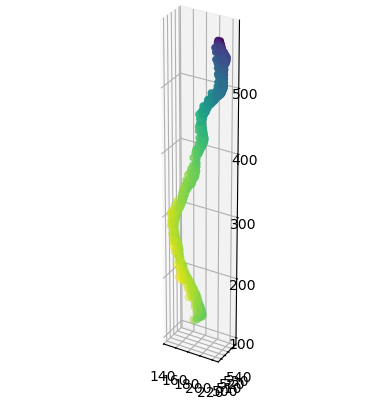

In [841]:
uv = FoldAnnotation.get_disk_harmonic_coords(fold_annotation.vertices, fold_annotation.triangles)
points = np.copy(fold_annotation.vertices[fold_annotation.indices])
points_coords = uv[fold_annotation.indices]
%matplotlib inline
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(points[:,0], points[:,1], points[:,2], c=points_coords[:,0])
ax.set_aspect('equal')
plt.show()

In [744]:
def fit_quadric(points):
    x, y, z = points[:,0], points[:,1], points[:,2]
    A = np.column_stack([x**2, y**2, z**2, x*y, x*z, y*z, x, y, z, np.ones(x.shape[0])])
    _, S, Vt = np.linalg.svd(A, full_matrices=True)
    return Vt[-1]

def evaluate_quadric(points, coeffs):
    """Evaluate the quadric at each point (residuals)."""
    x, y, z = points[:, 0], points[:, 1], points[:, 2]
    A, B, C, D, E, F, G, H, I, J = coeffs
    return (A*x**2 + B*y**2 + C*z**2 +
            D*x*y + E*x*z + F*y*z +
            G*x + H*y + I*z + J)


def quadric_residual_geometric(points, coeffs):
    x, y, z = points.T
    A,B,C,D,E,F,G,H,I,J = coeffs

    f = evaluate_quadric(points, coeffs)

    fx = 2*A*x + D*y + E*z + G
    fy = 2*B*y + D*x + F*z + H
    fz = 2*C*z + E*x + F*y + I

    grad_norm = np.sqrt(fx**2 + fy**2 + fz**2) + 1e-12
    return f / grad_norm


In [756]:
points = np.copy(fold_annotation.vertices[fold_annotation.indices])
np.savetxt('fold_points.txt', points)

In [751]:
points = np.copy(fold_annotation.vertices[fold_annotation.indices])
mean = points.mean(axis=0)
scale = np.std(points)
points = (points - mean) / scale
coeffs = fit_quadric(points)
from sklearn.decomposition import PCA
bounds = np.array([points.min(axis=0), points.max(axis=0)])
X, Y, Z = np.meshgrid(np.linspace(bounds[0,0], bounds[1,0], 50),
                      np.linspace(bounds[0,1], bounds[1,1], 50),
                      np.linspace(bounds[0,2], bounds[1,2], 50), indexing='xy')
grid_points = np.column_stack([X.ravel(), Y.ravel(), Z.ravel()])
residuals = evaluate_quadric(grid_points, coeffs)
residuals_3d = residuals.reshape(X.shape)
from skimage.measure import marching_cubes
verts, faces, normals, values = marching_cubes(residuals_3d, level=0)
fig = go.Figure()
fig.update_layout(
title="",
width=800, height=680,
scene=dict(
    xaxis_title='x', yaxis_title='y', zaxis_title='z',
    aspectmode='data',
    uirevision="keep"  # preserve camera/zoom
),
margin=dict(l=0, r=0, t=0, b=0),
legend=dict(itemsizing='constant')
)

mesh_trace = go.Mesh3d(
    x=verts[:, 0],
    y=verts[:, 1], 
    z=verts[:, 2],
    i=faces[:, 0],
    j=faces[:, 1],
    k=faces[:, 2],
    color='grey',
    opacity=0.5,
    name='mesh'
)
points_trace = go.Scatter3d(
    x=points[:, 0],
    y=points[:, 1],
    z=points[:, 2],
    mode='markers',
    marker=dict(color='red', size=5),
    name='data points'
)
palette = px.colors.qualitative.Plotly
fig.add_trace(mesh_trace)
fig.add_trace(points_trace)
fig.show()

In [674]:
fig = fold_annotation.visualize(display_vpaths=False, 
                                display_merged_path=True, 
                                additional_curves=[FoldAnnotation.construct_reference_frame_via_spline(fold_annotation.vertices, fold_annotation.compute_vpaths()[0], spline_smoothing_factor=1.0)[0]])